# Evaluation and analysis

This notebook performs the qualitative analysis of the performance of our ensemble of models.

In [1]:
import os
import random

import nibabel as nib
import numpy as np

### Setting paths and environment variables:

In [2]:
os.chdir('..')

In [3]:
os.getcwd()

'/home/ander/PycharmProjects/nnunet-ms-segmentation'

### Generic:

In [4]:
from custom_scripts.A_config import (
    ROOT,
    TEST_IMAGES_DIR,
    DATASET,
    CONFIGURATION,
    PLAN,
    MSSEG2_IMAGES_DIR,
    MSSEG2_LABELS_DIR,
    MSSEG2_PREDICTIONS_DIR,
    MSSEG2_ANALYSIS_DIR,
    Dataset
)

### Specific:

In [5]:
TRAINER = "nnUNetTrainerExtremeOversamplingEarlyStoppingLowLR"

In [6]:
TEST_DATASET = Dataset.msseg2

In [7]:
ALL_TEST_PREDICTIONS_FOLDER = ROOT / 'nnUNet_test_results'
TEST_SPECIFIC_FOLDER_NAME = TRAINER + '__' + PLAN + "__" + CONFIGURATION
TEST_PREDICTIONS_FOLDER = ALL_TEST_PREDICTIONS_FOLDER / DATASET / TEST_SPECIFIC_FOLDER_NAME

In [8]:
if TEST_DATASET == Dataset.msseg2:
    TEST_PREDICTIONS_FOLDER = MSSEG2_PREDICTIONS_DIR
    TEST_LABELS_DIR = MSSEG2_LABELS_DIR
    TEST_IMAGES_DIR = MSSEG2_IMAGES_DIR

## Analysing specific cases:

In [9]:
from custom_scripts import utils
import custom_scripts.F_evaluate_quantitative as equant

In [10]:
utils.TEST_PREDICTIONS_FOLDER = TEST_PREDICTIONS_FOLDER
equant.TEST_PREDICTIONS_FOLDER = TEST_PREDICTIONS_FOLDER

In [11]:
test_images = os.listdir(TEST_IMAGES_DIR)
test_ids = sorted({file_name.split(".")[0][:-5] for file_name in test_images})

In [149]:
sample_case_num_idx = random.randint(0, len(test_ids))
sample_case_id = test_ids.pop(sample_case_num_idx)
print(f"{sample_case_id = }")
sample_labels_path, sample_predictions_path = utils.get_paths(case_id=sample_case_id, dataset=TEST_DATASET,
                                                              labels=True, preds=True)

sample_case_id = 'patient16'


In [150]:
from nnunetv2.imageio.simpleitk_reader_writer import SimpleITKIO
from nnunetv2.evaluation.evaluate_predictions import compute_metrics

results = compute_metrics(
    reference_file=sample_labels_path,
    prediction_file=sample_predictions_path,
    image_reader_writer=SimpleITKIO(),
    labels_or_regions=[1, 2]
)

In [151]:
sample_b_image, sample_fu_image = utils.read_images(case_id=sample_case_id, dataset=TEST_DATASET)
sample_labels, sample_predictions = equant.read_labels_and_preds(case_id=sample_case_id, dataset=TEST_DATASET)

In [152]:
sample_b_image.shape

(182, 218, 182)

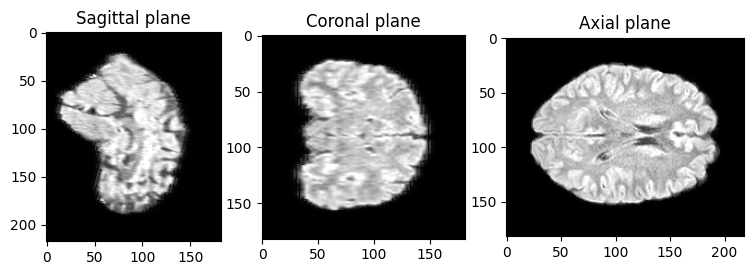

In [153]:
from custom_scripts.plotting import axes_plot

axes_plot(sample_im=sample_b_image)

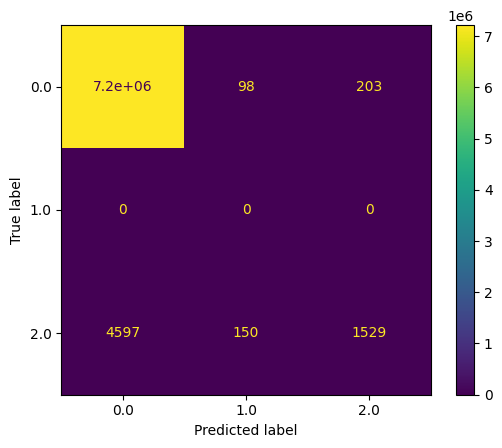

In [154]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true=sample_labels.flatten(), y_pred=sample_predictions.flatten())

In [155]:
sample_b_image_path, sample_fu_image_path = utils.get_paths(case_id=sample_case_id, dataset=TEST_DATASET,
                                                            basal_im=True, follow_up_im=True)
raw_sample_b_image = nib.load(sample_b_image_path)

### Visualizaciones de las imágenes y las máscaras:

In [156]:
from custom_scripts.utils import get_lesions_locations, get_lesion_confusion_array, ConfArrayVal2Type

#### Lesiones basales

In [157]:
from custom_scripts.plotting import plot_basal_lesion_eval

In [158]:
results['metrics'][1]

{'Dice': 0.0,
 'IoU': 0.0,
 'FP': 248,
 'TP': 0,
 'FN': 0,
 'TN': 7220784,
 'n_pred': 248,
 'n_ref': 0}

In [159]:
true_basal_lesion_locations = {f"t_{lesion_id}": value for lesion_id, value
                               in get_lesions_locations(labels=sample_labels, lesion_class=1).items()}
pred_basal_lesion_locations = {f"p_{lesion_id}": value for lesion_id, value
                               in get_lesions_locations(labels=sample_predictions, lesion_class=1).items()}
basal_lesion_locations = true_basal_lesion_locations | pred_basal_lesion_locations

In [160]:
sample_basal_lesion = random.choice(list(basal_lesion_locations.keys()))
sample_basal_lesion_central_voxel = random.choice(basal_lesion_locations[sample_basal_lesion])
sample_basal_lesion_centroid = tuple(np.mean(basal_lesion_locations[sample_basal_lesion], axis=0).astype(int))
del basal_lesion_locations[sample_basal_lesion]
sample_basal_lesion

'p_4'

In [161]:
basal_lesion_confusions = get_lesion_confusion_array(labels=sample_labels, predictions=sample_predictions,
                                                     lesion_class=1, masked=True)

In [162]:
sample_basal_lesion_type = ConfArrayVal2Type[basal_lesion_confusions[sample_basal_lesion_central_voxel]]
sample_basal_lesion_type

'FP'

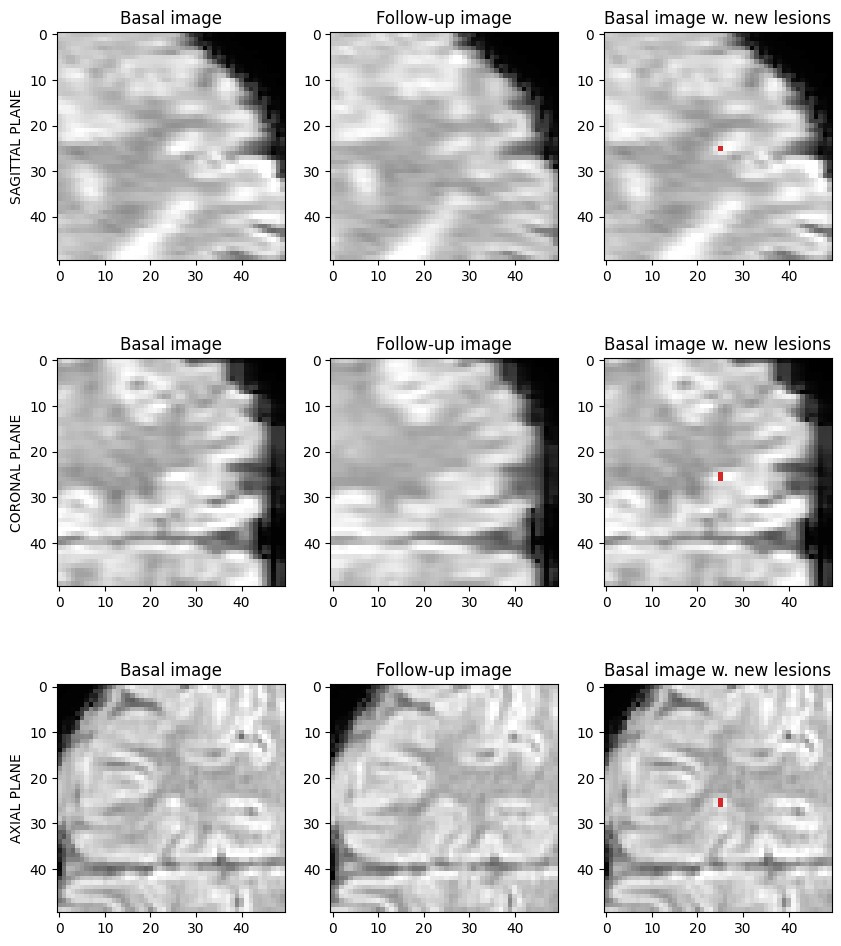

In [163]:
fig = plot_basal_lesion_eval(b_im=sample_b_image,
                             fu_im=sample_fu_image,
                             conf_mat=basal_lesion_confusions,
                             central_voxel=sample_basal_lesion_central_voxel, patch_size=25);

In [164]:
if TEST_DATASET == Dataset.msseg2:
    pass
else:
    TEST_ANALYSIS_DIR = TEST_PREDICTIONS_FOLDER / "Analysis"
    try:
        os.mkdir(TEST_ANALYSIS_DIR)
    except FileExistsError:
        pass
    fig.savefig(TEST_ANALYSIS_DIR / "BASAL" / f"{sample_case_id}_BASAL_{sample_basal_lesion_centroid}.png")

#### Lesiones nuevas

In [165]:
from custom_scripts.plotting import plot_new_lesion_eval

In [166]:
results['metrics'][2]

{'Dice': 0.38186813186813184,
 'IoU': 0.23599320882852293,
 'FP': 203,
 'TP': 1529,
 'FN': 4747,
 'TN': 7214553,
 'n_pred': 1732,
 'n_ref': 6276}

In [167]:
true_new_lesion_locations = {f"t_{lesion_id}": value for lesion_id, value
                             in get_lesions_locations(labels=sample_labels, lesion_class=2).items()}
pred_new_lesion_locations = {f"p_{lesion_id}": value for lesion_id, value
                             in get_lesions_locations(labels=sample_predictions, lesion_class=2).items()}
new_lesion_locations = true_new_lesion_locations | pred_new_lesion_locations

In [168]:
print(f"N of true new lesions: {len(true_new_lesion_locations)}")
print(f"N of predicted new lesions: {len(pred_new_lesion_locations)}")

N of true new lesions: 53
N of predicted new lesions: 14


In [169]:
sample_new_lesion = random.choice(list(new_lesion_locations.keys()))
sample_new_lesion_central_voxel = random.choice(new_lesion_locations[sample_new_lesion])
sample_new_lesion_centroid = tuple(np.mean(new_lesion_locations[sample_new_lesion], axis=0).astype(int))
del new_lesion_locations[sample_new_lesion]
sample_new_lesion

't_38'

In [170]:
new_lesion_confusion_array = get_lesion_confusion_array(labels=sample_labels, predictions=sample_predictions,
                                                        lesion_class=2, masked=True)

In [171]:
sample_new_lesion_type = ConfArrayVal2Type[new_lesion_confusion_array[sample_new_lesion_central_voxel]]
sample_new_lesion_type

'FN'

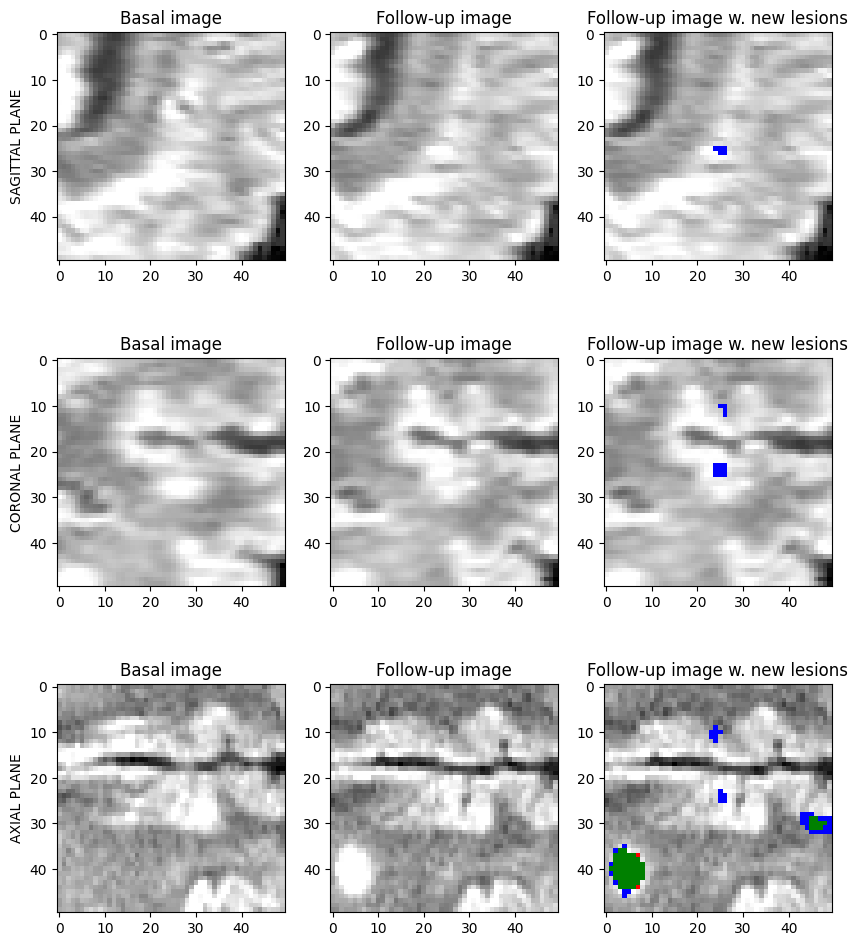

In [172]:
fig = plot_new_lesion_eval(b_im=sample_b_image, fu_im=sample_fu_image, conf_mat=new_lesion_confusion_array,
                           central_voxel=sample_new_lesion_central_voxel, patch_size=25)

In [146]:
if TEST_DATASET == Dataset.msseg2:
    if "patient" in sample_case_id:
        TEST_ANALYSIS_DIR = MSSEG2_ANALYSIS_DIR / "MS_OPEN_DATA"
    else:
        TEST_ANALYSIS_DIR = MSSEG2_ANALYSIS_DIR / "MSSEG2"
    try:
        os.mkdir(TEST_ANALYSIS_DIR)
    except FileExistsError:
        pass
    fig.savefig(TEST_ANALYSIS_DIR / f"{TEST_DATASET}_{sample_case_id}_NEW_{sample_new_lesion_centroid}.png")
else:
    TEST_ANALYSIS_DIR = TEST_PREDICTIONS_FOLDER / "Analysis"
    try:
        os.mkdir(TEST_ANALYSIS_DIR)
    except FileExistsError:
        pass
    fig.savefig(TEST_ANALYSIS_DIR / "NEW" / f"{sample_case_id}_NEW_{sample_new_lesion_centroid}.png")